# Medical Image Segmentation

In [1]:
#importing the libraries
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Sequential, Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf
import cv2

Using TensorFlow backend.


In [2]:
#inputs and path of the input images
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'U_NET/train/'
TEST_PATH = 'U_NET/validation/'

warnings.filterwarnings(action='ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

## Collect our file names for training and test date

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
train_ids

['00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552',
 '003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1',
 '00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e',
 '0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed',
 '01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf',
 '0280fa8f60f6bcae0f97d93c28f60be194f9309ff610dc5845e60455b0f87c21',
 '0287e7ee5b007c91ae2bd7628d09735e70496bc6127ecb7f3dd043e04ce37426',
 '02903040e19ddf92f452907644ad3822918f54af41dd85e5a3fe3e1b6d6f9339',
 '03398329ced0c23b9ac3fac84dd53a87d9ffe4d9d10f1b5fe8df8fac12380776',
 '03b9306f44e9b8951461623dcbd615550cdcf36ea93b203f2c8fa58ed1dffcbe',
 '03f583ec5018739f4abb9b3b4a580ac43bd933c4337ad8877aa18b1dfb59fc9a',
 '0402a81e75262469925ea893b6706183832e85324f7b1e08e634129f5d522cdd',
 '04acab7636c4cf61d288a5962f15fa456b7bde31a021e5deedfbf51288e4001e',
 '05040e2e959c3f5632558fc9683fec88f0010026c555b499066346f67fdd0e13',
 '0532c64c2fd0c4d3188cc751cdfd566b

In [5]:
len(train_ids)

670

In [6]:
len(test_ids)

65

## Creating of image masks of dimension 128x128 (black images)

In [7]:
print('Getting and resizing training images ... ')
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        
# Re-sizing our training images to 128 x 128
# Note sys.stdout prints info that can be cleared unlike print.
# Using TQDM allows us to create progress bars
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    
    # Now we take all masks associated with that image and combine them into one single mask
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    # Y_train is now our single mask associated with our image
    Y_train[n] = mask

Getting and resizing training images ... 


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [02:28<00:00,  4.52it/s]


In [8]:
#Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH))
sizes_test = []

for i,j in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + j
    image = imread(path + '/images/' + j + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([image.shape[0], image.shape[1]])
    image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test = image

print('Done!')

100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 56.43it/s]


Done!


## Lets see the images and masks

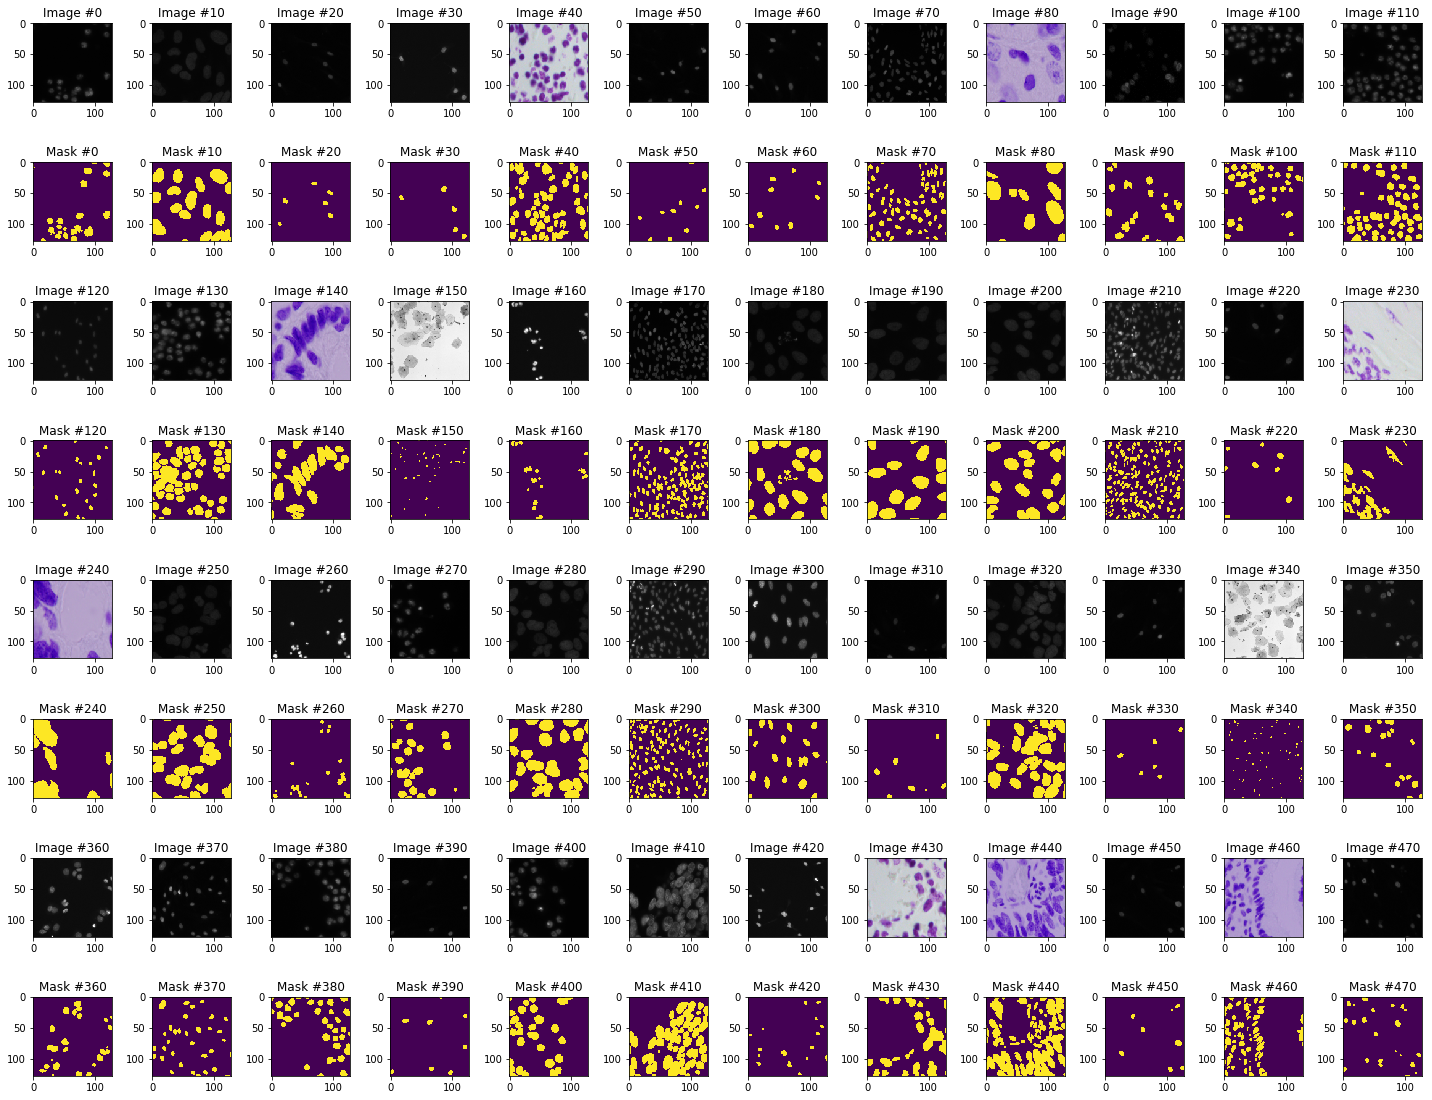

In [9]:
# Illustrate the train images and masks
plt.figure(figsize=(20,16))
x, y = 12,4
for i in range(y):  
    for j in range(x):
        plt.subplot(y*2, x, i*2*x+j+1)
        pos = i*120 + j*10
        plt.imshow(X_train[pos])
        plt.title('Image #{}'.format(pos))
        plt.tight_layout()
        
        plt.subplot(y*2, x, (i*2+1)*x+j+1)
        #We display the associated mask we just generated above with the training image
        plt.imshow(np.squeeze(Y_train[pos]))
        plt.title('Mask #{}'.format(pos))
        plt.tight_layout()
        
plt.show()

## IOU metric

In [10]:
#thanks to https://www.kaggle.com/aglotero/another-iou-metric

def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = label(y_true_in > 0.5)
    y_pred = label(y_pred_in > 0.5)
    
    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.array(np.mean(metric), dtype=np.float32)

def my_iou_metric(label, pred):
    metric_value = tf.py_func(iou_metric_batch, [label, pred], tf.float32)
    return metric_value

## Building U-Net Model

In [11]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

# Note our output is effectively a mask of 128 x 128 
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[my_iou_metric])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 128, 128, 16) 4624        concatenate_4[0][0]              
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 128, 128, 16) 0           conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 (Conv2D)              (None, 128, 128, 16) 2320        dropout_9[0][0]                  
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 1)  17          conv2d_18[0][0]                  
Total params: 1,941,105
Trainable params: 1,941,105
Non-trainable params: 0
__________________________________________________________________________________________________


## Fit our model

In [15]:
#lets put our callbacks
modelpath = r'D:\\Backup_of_exact_MY_REPO\\Medical Image Segmentation using U-Net\\nuclei_finder_unet.h5'
checkpoint = ModelCheckpoint(filepath=modelpath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, restore_best_weights=True)
callbacks = [checkpoint, early_stopping]

result = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=10, callbacks=callbacks)

Train on 603 samples, validate on 67 samples
Epoch 1/10
603/603 [==============================] - ETA: 2:27 - loss: 0.1317 - my_iou_metric: 0.263 - ETA: 2:23 - loss: 0.1439 - my_iou_metric: 0.247 - ETA: 2:18 - loss: 0.1512 - my_iou_metric: 0.237 - ETA: 2:14 - loss: 0.1551 - my_iou_metric: 0.247 - ETA: 2:10 - loss: 0.1578 - my_iou_metric: 0.246 - ETA: 2:06 - loss: 0.1529 - my_iou_metric: 0.257 - ETA: 2:02 - loss: 0.1531 - my_iou_metric: 0.268 - ETA: 1:58 - loss: 0.1523 - my_iou_metric: 0.273 - ETA: 1:54 - loss: 0.1564 - my_iou_metric: 0.266 - ETA: 1:50 - loss: 0.1498 - my_iou_metric: 0.278 - ETA: 1:46 - loss: 0.1522 - my_iou_metric: 0.279 - ETA: 1:42 - loss: 0.1548 - my_iou_metric: 0.282 - ETA: 1:38 - loss: 0.1541 - my_iou_metric: 0.277 - ETA: 1:35 - loss: 0.1533 - my_iou_metric: 0.272 - ETA: 1:30 - loss: 0.1535 - my_iou_metric: 0.267 - ETA: 1:27 - loss: 0.1519 - my_iou_metric: 0.269 - ETA: 1:23 - loss: 0.1493 - my_iou_metric: 0.266 - ETA: 1:19 - loss: 0.1503 - my_iou_metric: 0.265 - E

603/603 [==============================] - ETA: 2:25 - loss: 0.0779 - my_iou_metric: 0.463 - ETA: 2:23 - loss: 0.1211 - my_iou_metric: 0.385 - ETA: 2:21 - loss: 0.1175 - my_iou_metric: 0.378 - ETA: 2:19 - loss: 0.1278 - my_iou_metric: 0.354 - ETA: 2:15 - loss: 0.1189 - my_iou_metric: 0.357 - ETA: 2:11 - loss: 0.1118 - my_iou_metric: 0.363 - ETA: 2:12 - loss: 0.1094 - my_iou_metric: 0.370 - ETA: 2:09 - loss: 0.1107 - my_iou_metric: 0.370 - ETA: 2:04 - loss: 0.1119 - my_iou_metric: 0.379 - ETA: 2:00 - loss: 0.1080 - my_iou_metric: 0.388 - ETA: 1:55 - loss: 0.1074 - my_iou_metric: 0.391 - ETA: 1:50 - loss: 0.1067 - my_iou_metric: 0.393 - ETA: 1:45 - loss: 0.1052 - my_iou_metric: 0.399 - ETA: 1:40 - loss: 0.1059 - my_iou_metric: 0.399 - ETA: 1:35 - loss: 0.1080 - my_iou_metric: 0.392 - ETA: 1:31 - loss: 0.1056 - my_iou_metric: 0.390 - ETA: 1:26 - loss: 0.1055 - my_iou_metric: 0.390 - ETA: 1:22 - loss: 0.1058 - my_iou_metric: 0.388 - ETA: 1:19 - loss: 0.1065 - my_iou_metric: 0.387 - ETA: 1:

Epoch 00007: val_loss did not improve from 0.09304
Epoch 8/10
603/603 [==============================] - ETA: 2:23 - loss: 0.0566 - my_iou_metric: 0.485 - ETA: 2:20 - loss: 0.0591 - my_iou_metric: 0.462 - ETA: 2:16 - loss: 0.0615 - my_iou_metric: 0.458 - ETA: 2:12 - loss: 0.0657 - my_iou_metric: 0.463 - ETA: 2:08 - loss: 0.0764 - my_iou_metric: 0.454 - ETA: 2:06 - loss: 0.0800 - my_iou_metric: 0.440 - ETA: 2:06 - loss: 0.0889 - my_iou_metric: 0.433 - ETA: 2:06 - loss: 0.0870 - my_iou_metric: 0.444 - ETA: 2:02 - loss: 0.0856 - my_iou_metric: 0.447 - ETA: 1:58 - loss: 0.0862 - my_iou_metric: 0.448 - ETA: 1:54 - loss: 0.0843 - my_iou_metric: 0.455 - ETA: 1:50 - loss: 0.0853 - my_iou_metric: 0.445 - ETA: 1:45 - loss: 0.0846 - my_iou_metric: 0.450 - ETA: 1:40 - loss: 0.0833 - my_iou_metric: 0.452 - ETA: 1:36 - loss: 0.0850 - my_iou_metric: 0.449 - ETA: 1:31 - loss: 0.0842 - my_iou_metric: 0.451 - ETA: 1:27 - loss: 0.0869 - my_iou_metric: 0.452 - ETA: 1:23 - loss: 0.0874 - my_iou_metric: 0.4

## Generating our predictions for training and validation data

In [17]:
#first 90% used for training
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)

#last 10% used for validation
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

#threshold predictions
preds_train_t = (preds_train>0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

67/67 [==============================] - ETA:  - ETA:  - 7s 109ms/step


## showing our predicted masks on our training data

C:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


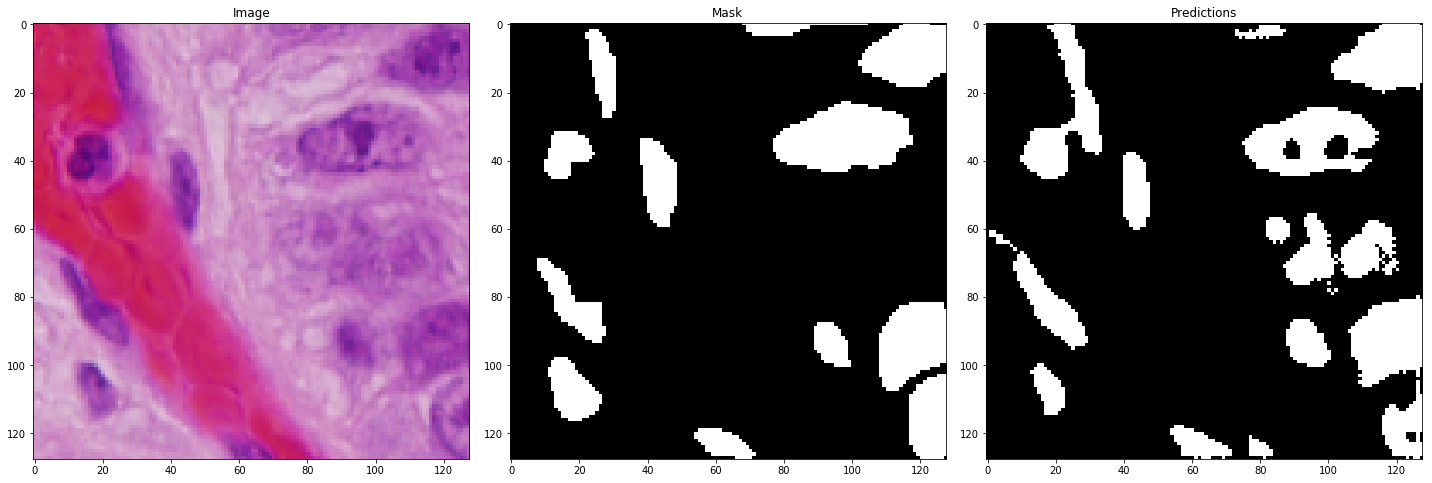

In [18]:
ix = random.randint(0, 602)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(131)
imshow(X_train[ix])
plt.title("Image")

# Our original combined mask  
plt.subplot(132)
imshow(np.squeeze(Y_train[ix]))
plt.title("Mask")

# The mask our U-Net model predicts
plt.subplot(133)
imshow(np.squeeze(preds_train_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

## showing our predicted images to our validation data

C:\Anaconda\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
C:\Anaconda\lib\site-packages\matplotlib\axes\_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


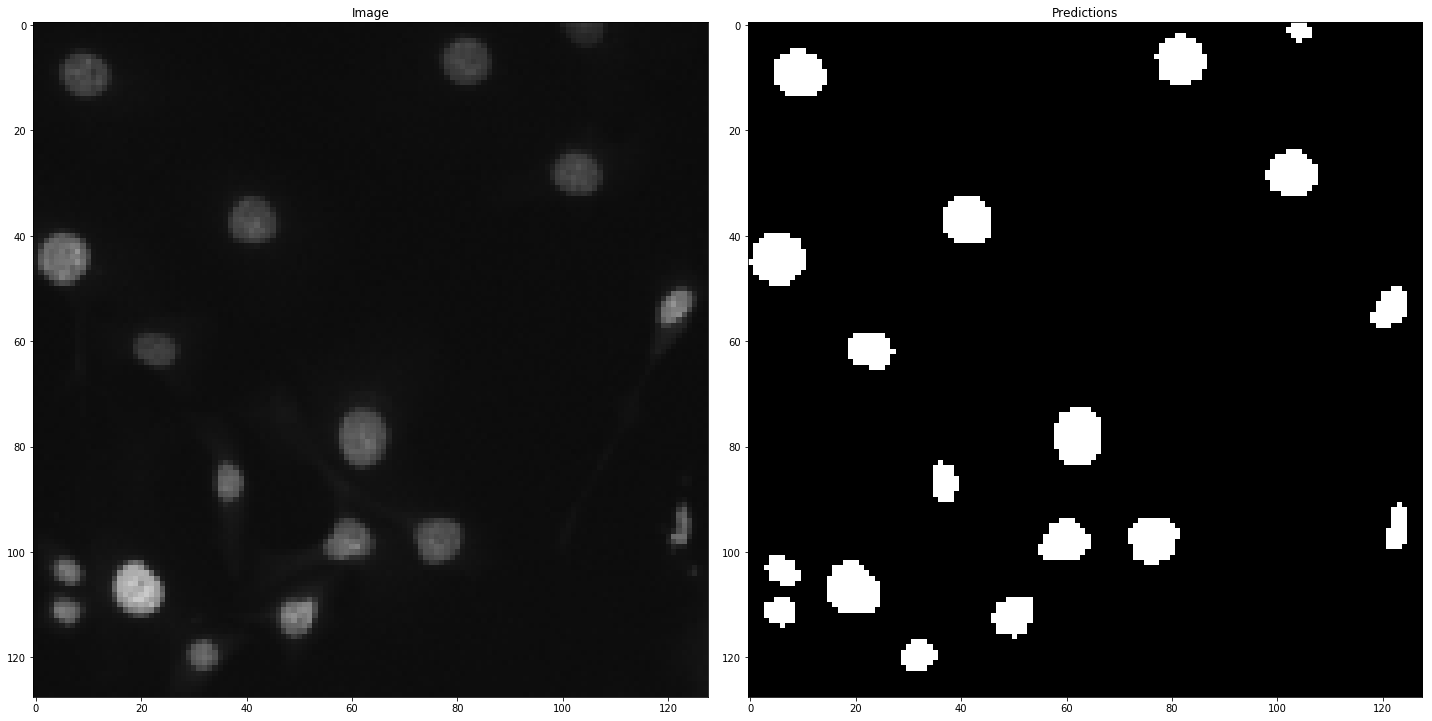

In [19]:
# Ploting our predicted masks
ix = random.randint(602, 668)
plt.figure(figsize=(20,20))

# Our original training image
plt.subplot(121)
imshow(X_train[ix])
plt.title("Image")

# The mask our U-Net model predicts
plt.subplot(122)
ix = ix - 603
imshow(np.squeeze(preds_val_t[ix] > 0.5))
plt.title("Predictions")
plt.show()

I think its a very good prediction because of the metric score we have used. Thanks to the author from kaggle who posted this metric!!!

## That's the end of the code